# Konkuk University
# Industrial Engineering Graduation Thesis
## Kimchi Premium Prediction

## 0. 기본 상수 설정
### 패키지 설정

In [1]:
import ccxt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import FinanceDataReader as fdr
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from binance.client import Client

#python 버전 3.0이상에서 기본으로 지원, warning 때문에 넣은 옵션
pd.options.mode.copy_on_write = False

const_var = {
        'exchange' : ccxt.upbit(), 
        'cur_market' : 'BTC/KRW',
        'main_time_period' : '1d',
        'start_time' : '2023-01-02 00:00:00', # 시립대: 2017-11-06 ~ 종료2022-09-24 // 9/24로 해야 9/23까지 받아짐
        'end_time' : '2024-09-02 00:00:00', 
        # 'start_time' : '2022-03-10 00:00:00', # 금리 인상~ 최신 : 2022-03-10 ~ 2024-05-20
        # 'end_time' : '2024-05-20 00:00:00'
}

# API 발급 후 입력
api_key = "o1Ud3ojcyL1jNhze7aHLUKmT61gso6dKCMZjj3w23NsST2tnyV6OKWyo5DfGfhX5"
api_secret = "8ODvDPVtTnZibb44ZeuW7LPkAvdTumbIDHFmTwvrMfOakF6nyk7hBOWUXXjpJnmI"

# 초기 설정 시각 보존
origin_start = const_var['start_time']
origins_end = const_var['end_time']

In [2]:
const_var

{'exchange': ccxt.upbit(),
 'cur_market': 'BTC/KRW',
 'main_time_period': '1d',
 'start_time': '2023-01-02 00:00:00',
 'end_time': '2024-09-02 00:00:00'}

In [3]:
# 시작시각에서 부터 dataFrame 가져오기
def get_df(const_var):
    ex = const_var['exchange']
    main_time = 'close({})'.format(const_var['main_time_period'])
    from_ts = ex.parse8601(const_var['start_time'])
    ohlcv = ex.fetch_ohlcv(const_var['cur_market'],const_var['main_time_period'], since=from_ts, limit=199)
    df = pd.DataFrame(ohlcv, columns=['time', 'open','high','low',main_time, 'volume'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')

    return df

# DataFrame 종료시각까지 이어 붙이기
def merge_more (df, const_var) :
    const_var['start_time'] = df['time'].iloc[-1].strftime("%Y-%m-%d %H:%M:%S") #새로운 df의 마지막 시각
    df2 = get_df(const_var)[1:]
    merged_df = pd.concat([df, df2])

    return merged_df

## 1. 데이터 수집 및 단위 변환

In [5]:
# Upbit DataFrame 만들기
const_var['exchange'] = ccxt.upbit()
df = get_df(const_var)

while(df['time'].iloc[-1].strftime("%Y-%m-%d %H:%M:%S") < origins_end) :
    df = merge_more(df, const_var)

const_var['start_time'] = origin_start
df = df.reset_index(drop=True)
df_upbit = df[['time','close({})'.format(const_var['main_time_period']),'volume','high','low']]
df_upbit.rename(columns={'close({})'.format(const_var['main_time_period']):'Upbit(Price)', 'volume' : 'Upbit(Vol)','high':'Upbit(High)', 'low':'Upbit(Low)'}, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_30904\2765203704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upbit.rename(columns={'close({})'.format(const_var['main_time_period']):'Upbit(Price)', 'volume' : 'Upbit(Vol)','high':'Upbit(High)', 'low':'Upbit(Low)'}, inplace=True)


In [6]:
# Binance 데이터 불러오기
client = Client(api_key, api_secret)
btc_usdt = client.get_symbol_ticker(symbol="BTCUSDT")

day = client.get_historical_klines(
    symbol="BTCUSDT",
    interval=const_var['main_time_period'],
    start_str=const_var['start_time'],
    limit=1000
)

df = pd.DataFrame(day)

df['time'] = pd.to_numeric(df.loc[:,0]*1000000)
df['time'] = pd.to_datetime(df['time'])
df['Binance(Price)'] = df.loc[:,4].astype(float)
df['Binance(Vol)'] = df.loc[:,5].astype(float)
df = df[['time', 'Binance(Price)', 'Binance(Vol)']]

# (업비트 + 바이낸스)파일 합치기
df = pd.merge(df_upbit, df, on ='time', how='left')

In [12]:
df

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol)
0,2023-01-02,21215000.0,2578.844531,21400000.0,21047000.0,16672.87,121888.57191
1,2023-01-03,21351000.0,2097.615306,21451000.0,21178000.0,16675.18,159541.53733
2,2023-01-04,21588000.0,2479.248182,21732000.0,21341000.0,16850.36,220362.18862
3,2023-01-05,21575000.0,3563.010235,21641000.0,21404000.0,16831.85,163473.56641
4,2023-01-06,21517000.0,3285.376716,21593000.0,21280000.0,16950.65,207401.28415
...,...,...,...,...,...,...,...
698,2024-11-30,133701000.0,2374.866974,134809000.0,133600000.0,96407.99,14503.83306
699,2024-12-01,133802000.0,2835.146498,135199000.0,133297000.0,97185.18,16938.60452
700,2024-12-02,133535000.0,5356.774825,135800000.0,132260000.0,95840.62,37958.66981
701,2024-12-03,133700000.0,18097.084256,134680000.0,88266000.0,95849.69,35827.32283


In [14]:
df_ex = fdr.DataReader('USD/KRW','2021-01-02', '2022-09-02')
df_ex

,Open,High,Low,Close,Volume,Adj Close
2021-01-01,1083.500000,1088.500000,1083.500000,1084.650024,0,1084.650024
2021-01-04,1084.729980,1086.469971,1079.219971,1084.729980,0,1084.729980
2021-01-05,1085.609985,1089.729980,1081.670044,1086.619995,0,1086.619995
2021-01-06,1085.650024,1088.589966,1083.250000,1086.449951,0,1086.449951
2021-01-07,1085.250000,1096.000000,1084.829956,1086.949951,0,1086.949951
...,...,...,...,...,...,...
2022-08-25,1334.439941,1337.819946,1327.349976,1334.439941,0,1334.439941
2022-08-28,1341.180054,1351.959961,1341.180054,1341.180054,0,1341.180054
2022-08-29,1345.729980,1352.640015,1342.890015,1345.729980,0,1345.729980
2022-08-30,1350.189941,1351.699951,1337.400024,1350.189941,0,1350.189941


In [24]:
# 환율 데이터 가져오기
df_ex = fdr.DataReader('USD/KRW',const_var['start_time'], const_var['end_time'])
df_ex.reset_index(inplace=True)
df_ex

,index,Open,High,Low,Close,Volume,Adj Close
0,2023-01-02,1260.910034,1273.930054,1256.550049,1260.910034,0,1260.910034
1,2023-01-03,1270.099976,1278.969971,1264.390015,1270.099976,0,1270.099976
2,2023-01-04,1279.079956,1279.719971,1267.560059,1279.079956,0,1279.079956
3,2023-01-05,1271.079956,1278.229980,1265.739990,1271.079956,0,1271.079956
4,2023-01-06,1274.180054,1274.180054,1253.010010,1274.180054,0,1274.180054
...,...,...,...,...,...,...,...
430,2024-08-25,1323.880005,1328.699951,1317.099976,1323.880005,0,1323.880005
431,2024-08-26,1326.640015,1334.849976,1326.640015,1326.640015,0,1326.640015
432,2024-08-27,1326.359985,1339.479980,1326.359985,1326.359985,0,1326.359985
433,2024-08-28,1336.689941,1338.160034,1326.709961,1336.689941,0,1336.689941


In [26]:
df_ex.rename(columns={'index':'time','Close':'Exchange(Rate)'},inplace=True)
df_ex = df_ex[['time','Exchange(Rate)']]

# (+환율) 파일 합치기
df = pd.merge(df, df_ex, on ='time', how='left')

In [28]:
df

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate)
0,2023-01-02,21215000.0,2578.844531,21400000.0,21047000.0,16672.87,121888.57191,1260.910034
1,2023-01-03,21351000.0,2097.615306,21451000.0,21178000.0,16675.18,159541.53733,1270.099976
2,2023-01-04,21588000.0,2479.248182,21732000.0,21341000.0,16850.36,220362.18862,1279.079956
3,2023-01-05,21575000.0,3563.010235,21641000.0,21404000.0,16831.85,163473.56641,1271.079956
4,2023-01-06,21517000.0,3285.376716,21593000.0,21280000.0,16950.65,207401.28415,1274.180054
...,...,...,...,...,...,...,...,...
698,2024-11-30,133701000.0,2374.866974,134809000.0,133600000.0,96407.99,14503.83306,NaN
699,2024-12-01,133802000.0,2835.146498,135199000.0,133297000.0,97185.18,16938.60452,NaN
700,2024-12-02,133535000.0,5356.774825,135800000.0,132260000.0,95840.62,37958.66981,NaN
701,2024-12-03,133700000.0,18097.084256,134680000.0,88266000.0,95849.69,35827.32283,NaN


In [30]:
# KOSPI 데이터 가져오기
df_kospi = fdr.DataReader('KS11', const_var['start_time'], const_var['end_time'])
df_kospi.reset_index(inplace=True)
df_kospi.rename(columns={'Date':'time','Close':'Kospi(Price)', 'Volume':'Kospi(Vol)'},inplace=True)
df_kospi = df_kospi[['time','Kospi(Price)','Kospi(Vol)']]

# (+Kospi) 데이터 합치기
df = pd.merge(df, df_kospi, on ='time', how='left')

In [35]:
# NASDAQ 데이터 가져오기
df_Nasdaq = fdr.DataReader('IXIC', const_var['start_time'], const_var['end_time'])
df_Nasdaq.reset_index(inplace=True)
df_Nasdaq.rename(columns={'index':'time','Close':'Nasdaq(Price)', 'Volume':'Nasdaq(Vol)'},inplace=True)
df_Nasdaq = df_Nasdaq[['time','Nasdaq(Price)','Nasdaq(Vol)']]

# (+Nasdaq) 데이터 합치기
df = pd.merge(df, df_Nasdaq, on ='time', how='left')

In [37]:
# VIX 데이터 가져오기
df_VIX = fdr.DataReader('VIX', const_var['start_time'], const_var['end_time'])
df_VIX.reset_index(inplace=True)
df_VIX.rename(columns={'index':'time','Close':'VIX(Price)'},inplace=True)
df_VIX = df_VIX[['time','VIX(Price)']]

# (+VIX) 데이터 합치기
df = pd.merge(df, df_VIX, on ='time', how='left')

In [39]:
# 금 선물 데이터 가져오기
df_Gold = fdr.DataReader('GC=F', const_var['start_time'], const_var['end_time'])
df_Gold.reset_index(inplace=True)
df_Gold.rename(columns={'index':'time','Close':'Gold(Price)','Volume':'Gold(Vol)'},inplace=True)
df_Gold = df_Gold[['time','Gold(Price)', 'Gold(Vol)']]

# (+Gold) 데이터 합치기
df = pd.merge(df, df_Gold, on ='time', how='left')

In [41]:
# 원유(WTI) 선물 데이터 가져오기
df_WTI = fdr.DataReader('CL=F', const_var['start_time'], const_var['end_time'])
df_WTI.reset_index(inplace=True)
df_WTI.rename(columns={'index':'time','Close':'WTI(Price)','Volume':'WTI(Vol)'},inplace=True)
df_WTI = df_WTI[['time','WTI(Price)', 'WTI(Vol)']]

# (+WTI) 데이터 합치기
df = pd.merge(df, df_WTI, on ='time', how='left')

In [47]:
df_TreasuryGap = fdr.DataReader('FRED:T10Y2Y', const_var['start_time'], const_var['end_time'])
df_TreasuryGap.reset_index(inplace=True)
df_TreasuryGap

,DATE,T10Y2Y
0,2023-01-03,-0.61
1,2023-01-04,-0.67
2,2023-01-05,-0.74
3,2023-01-06,-0.69
4,2023-01-09,-0.66
...,...,...
430,2024-08-27,0.00
431,2024-08-28,0.01
432,2024-08-29,0.00
433,2024-08-30,0.00


In [49]:
# 미국 장단기 금리차(TreasuryGap) 선물 데이터 가져오기
df_TreasuryGap = fdr.DataReader('FRED:T10Y2Y', const_var['start_time'], const_var['end_time'])
df_TreasuryGap.reset_index(inplace=True)
df_TreasuryGap.rename(columns={'DATE':'time','T10Y2Y':'TreasuryGap'},inplace=True)
df_TreasuryGap = df_TreasuryGap[['time','TreasuryGap']]

# (+TreasuryGap) 데이터 합치기
df = pd.merge(df, df_TreasuryGap, on ='time', how='left')

In [51]:
# Dollar Index (ICDX) 데이터 가져오기
df_ICDX = fdr.DataReader('^NYICDX', const_var['start_time'], const_var['end_time'])
df_ICDX.reset_index(inplace=True)
df_ICDX.rename(columns={'index':'time','Close':'ICDX'},inplace=True)
df_ICDX = df_ICDX[['time','ICDX']]

# (+ICDX) 데이터 합치기
df = pd.merge(df, df_ICDX, on ='time', how='left')

In [53]:
df

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX
0,2023-01-02,21215000.0,2578.844531,21400000.0,21047000.0,16672.87,121888.57191,1260.910034,2225.67,346344799.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-03,21351000.0,2097.615306,21451000.0,21178000.0,16675.18,159541.53733,1270.099976,2218.68,410245325.0,10386.980469,4.780650e+09,22.900000,1839.699951,29.0,76.930000,338520.0,-0.61,104.519997
2,2023-01-04,21588000.0,2479.248182,21732000.0,21341000.0,16850.36,220362.18862,1279.079956,2255.98,412841149.0,10458.759766,5.085380e+09,22.010000,1852.800049,25.0,72.839996,352434.0,-0.67,104.250000
3,2023-01-05,21575000.0,3563.010235,21641000.0,21404000.0,16831.85,163473.56641,1271.079956,2264.65,430977022.0,10305.240234,4.764270e+09,22.459999,1834.800049,24.0,73.669998,300731.0,-0.74,105.040001
4,2023-01-06,21517000.0,3285.376716,21593000.0,21280000.0,16950.65,207401.28415,1274.180054,2289.97,398606581.0,10569.290039,5.199780e+09,21.129999,1864.199951,26.0,73.769997,258128.0,-0.69,103.879997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,2024-11-30,133701000.0,2374.866974,134809000.0,133600000.0,96407.99,14503.83306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699,2024-12-01,133802000.0,2835.146498,135199000.0,133297000.0,97185.18,16938.60452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,2024-12-02,133535000.0,5356.774825,135800000.0,132260000.0,95840.62,37958.66981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701,2024-12-03,133700000.0,18097.084256,134680000.0,88266000.0,95849.69,35827.32283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# 숫자 단위 변형
# $표기로 업비트 변환
df['Upbit(High)'] = df['Upbit(High)']/df['Exchange(Rate)']
df['Upbit(Low)'] = df['Upbit(Low)']/df['Exchange(Rate)']
df['Upbit(Price)'] = df['Upbit(Price)']/df['Exchange(Rate)']

# 거래량을 $표시 거래대금으로 변환
df['Binance($_Vol)'] = df['Binance(Vol)']*df['Binance(Price)']
df['Upbit($_Vol)'] = df['Upbit(Vol)']*df['Upbit(Price)']

# 변동성,비유동성
df['Volatility'] = (df['Upbit(High)']-df['Upbit(Low)'])/df['Upbit(Price)'] *100
df['Illiquidity'] = abs(df['Upbit(Price)'].pct_change(periods=1, fill_method='bfill')) /df['Upbit(Vol)'] *100

# kimchi Primium
df['kimchiP']=(df['Upbit(Price)']-df['Binance(Price)'])/(df['Binance(Price)'])

# 파일 저장
df.to_csv('test3.csv')

In [75]:
df[df['time']=='2024-08-29']

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),...,Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP
605,2024-08-29,60613.108235,2539.082478,62046.095445,60133.695236,59359.01,27020.90743,1332.880005,2662.28,288835634.0,...,3966.0,75.910004,408147.0,0.0,101.339996,1.603934e+09,1.539017e+08,3.155093,0.000221,0.021127


In [99]:
df1=df.iloc[:606,]
df1

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),...,Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP
0,2023-01-02,16825.149634,2578.844531,16971.869063,16691.912531,16672.87,121888.57191,1260.910034,2225.67,346344799.0,...,NaN,NaN,NaN,NaN,NaN,2.032232e+09,4.338945e+07,1.663917,NaN,0.009133
1,2023-01-03,16810.487686,2097.615306,16889.221646,16674.277936,16675.18,159541.53733,1270.099976,2218.68,410245325.0,...,29.0,76.930000,338520.0,-0.61,104.519997,2.660384e+09,3.526194e+07,1.278629,0.000042,0.008114
2,2023-01-04,16877.756467,2479.248182,16990.337388,16684.648914,16850.36,220362.18862,1279.079956,2255.98,412841149.0,...,25.0,72.839996,352434.0,-0.67,104.250000,3.713182e+09,4.184415e+07,1.811191,0.000161,0.001626
3,2023-01-05,16973.755189,3563.010235,17025.679539,16839.223920,16831.85,163473.56641,1271.079956,2264.65,430977022.0,...,24.0,73.669998,300731.0,-0.74,105.040001,2.751563e+09,6.047766e+07,1.098494,0.000160,0.008431
4,2023-01-06,16886.938339,3285.376716,16946.584540,16700.936369,16950.65,207401.28415,1274.180054,2289.97,398606581.0,...,26.0,73.769997,258128.0,-0.69,103.879997,3.515587e+09,5.547995e+07,1.454664,0.000156,-0.003759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,2024-08-25,65152.430494,1698.816382,65700.063208,64514.910479,64220.00,12305.47977,1323.880005,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.902579e+08,1.106820e+08,1.819046,0.000000,0.014519
602,2024-08-26,63625.398803,2260.537399,65224.174640,63625.398803,62834.00,19470.05276,1326.640015,2698.01,333687885.0,...,290.0,77.419998,409675.0,-0.09,100.849998,1.223381e+09,1.438276e+08,2.512795,0.001037,0.012595
603,2024-08-27,61031.696443,4066.749057,63929.853838,60406.677587,59415.00,35135.94178,1326.359985,2689.25,264056855.0,...,100.0,75.529999,331162.0,0.00,100.550003,2.087602e+09,2.482006e+08,5.772699,0.001002,0.027210
604,2024-08-28,60275.010310,3848.303642,61267.012987,59512.679445,59034.90,36868.54275,1336.689941,2689.83,280773871.0,...,2353.0,74.519997,337361.0,0.01,101.089996,2.176531e+09,2.319565e+08,2.910549,0.000322,0.021006


In [115]:
df2

,index,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),...,Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP
0,1,2023-01-03,16810.487686,2097.615306,16889.221646,16674.277936,16675.18,159541.53733,1270.099976,2218.68,...,29.0,76.930000,338520.0,-0.61,104.519997,2.660384e+09,3.526194e+07,1.278629,0.000042,0.008114
1,2,2023-01-04,16877.756467,2479.248182,16990.337388,16684.648914,16850.36,220362.18862,1279.079956,2255.98,...,25.0,72.839996,352434.0,-0.67,104.250000,3.713182e+09,4.184415e+07,1.811191,0.000161,0.001626
2,3,2023-01-05,16973.755189,3563.010235,17025.679539,16839.223920,16831.85,163473.56641,1271.079956,2264.65,...,24.0,73.669998,300731.0,-0.74,105.040001,2.751563e+09,6.047766e+07,1.098494,0.000160,0.008431
3,4,2023-01-06,16886.938339,3285.376716,16946.584540,16700.936369,16950.65,207401.28415,1274.180054,2289.97,...,26.0,73.769997,258128.0,-0.69,103.879997,3.515587e+09,5.547995e+07,1.454664,0.000156,-0.003759
4,7,2023-01-09,17284.177188,3454.033478,17435.029624,17262.626840,17178.26,266211.52723,1252.880005,2350.19,...,62.0,74.629997,329290.0,-0.66,103.000000,4.573051e+09,5.970013e+07,0.997460,0.000000,0.006166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,598,2024-08-22,61217.281760,2138.235685,62036.966105,60677.544254,60375.84,21241.20588,1339.540039,2707.67,...,210.0,73.010002,334117.0,-0.13,101.510002,1.282456e+09,1.308970e+08,2.220650,0.000709,0.013937
342,602,2024-08-26,63625.398803,2260.537399,65224.174640,63625.398803,62834.00,19470.05276,1326.640015,2698.01,...,290.0,77.419998,409675.0,-0.09,100.849998,1.223381e+09,1.438276e+08,2.512795,0.001037,0.012595
343,603,2024-08-27,61031.696443,4066.749057,63929.853838,60406.677587,59415.00,35135.94178,1326.359985,2689.25,...,100.0,75.529999,331162.0,0.00,100.550003,2.087602e+09,2.482006e+08,5.772699,0.001002,0.027210
344,604,2024-08-28,60275.010310,3848.303642,61267.012987,59512.679445,59034.90,36868.54275,1336.689941,2689.83,...,2353.0,74.519997,337361.0,0.01,101.089996,2.176531e+09,2.319565e+08,2.910549,0.000322,0.021006


In [121]:
df2.drop(['index'],axis=1,inplace=True)
df2

C:\Users\USER\AppData\Local\Temp\ipykernel_30904\780011670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['index'],axis=1,inplace=True)


,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),...,Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP
0,2023-01-03,16810.487686,2097.615306,16889.221646,16674.277936,16675.18,159541.53733,1270.099976,2218.68,410245325.0,...,29.0,76.930000,338520.0,-0.61,104.519997,2.660384e+09,3.526194e+07,1.278629,0.000042,0.008114
1,2023-01-04,16877.756467,2479.248182,16990.337388,16684.648914,16850.36,220362.18862,1279.079956,2255.98,412841149.0,...,25.0,72.839996,352434.0,-0.67,104.250000,3.713182e+09,4.184415e+07,1.811191,0.000161,0.001626
2,2023-01-05,16973.755189,3563.010235,17025.679539,16839.223920,16831.85,163473.56641,1271.079956,2264.65,430977022.0,...,24.0,73.669998,300731.0,-0.74,105.040001,2.751563e+09,6.047766e+07,1.098494,0.000160,0.008431
3,2023-01-06,16886.938339,3285.376716,16946.584540,16700.936369,16950.65,207401.28415,1274.180054,2289.97,398606581.0,...,26.0,73.769997,258128.0,-0.69,103.879997,3.515587e+09,5.547995e+07,1.454664,0.000156,-0.003759
4,2023-01-09,17284.177188,3454.033478,17435.029624,17262.626840,17178.26,266211.52723,1252.880005,2350.19,342095527.0,...,62.0,74.629997,329290.0,-0.66,103.000000,4.573051e+09,5.970013e+07,0.997460,0.000000,0.006166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2024-08-22,61217.281760,2138.235685,62036.966105,60677.544254,60375.84,21241.20588,1339.540039,2707.67,441756204.0,...,210.0,73.010002,334117.0,-0.13,101.510002,1.282456e+09,1.308970e+08,2.220650,0.000709,0.013937
342,2024-08-26,63625.398803,2260.537399,65224.174640,63625.398803,62834.00,19470.05276,1326.640015,2698.01,333687885.0,...,290.0,77.419998,409675.0,-0.09,100.849998,1.223381e+09,1.438276e+08,2.512795,0.001037,0.012595
343,2024-08-27,61031.696443,4066.749057,63929.853838,60406.677587,59415.00,35135.94178,1326.359985,2689.25,264056855.0,...,100.0,75.529999,331162.0,0.00,100.550003,2.087602e+09,2.482006e+08,5.772699,0.001002,0.027210
344,2024-08-28,60275.010310,3848.303642,61267.012987,59512.679445,59034.90,36868.54275,1336.689941,2689.83,280773871.0,...,2353.0,74.519997,337361.0,0.01,101.089996,2.176531e+09,2.319565e+08,2.910549,0.000322,0.021006


In [123]:
df2.to_csv('data.csv')

## 2. 변수간 상관관계 분석

In [346]:
# 원본파일 백업
df_0 = df

# 환율이 존재하는 행만 수집(미국과 한국의 동시영업일)
is_nasdaq = (df_0['Nasdaq(Price)'].isnull()==False)
df_0= df_0[is_nasdaq]
df_0.reset_index(inplace=True)

# 상관관계 분석
pd.set_option('display.max_columns', 30)
corr_df=df_0.corr()
corr_df

,index,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP
index,1.000000,1.000000,0.484289,-0.115905,0.474937,0.484707,0.473693,-0.373079,0.229054,0.121367,-0.300639,0.675344,0.022138,-0.825683,0.668040,-0.006495,-0.701045,0.119447,-0.477926,-0.148204,-0.281106,0.203686,-0.134136,-0.042508,0.386045
time,1.000000,1.000000,0.484289,-0.115905,0.474937,0.484707,0.473693,-0.373079,0.229054,0.121367,-0.300639,0.675344,0.022138,-0.825683,0.668040,-0.006495,-0.701045,0.119447,-0.477926,-0.148204,-0.281106,0.203686,-0.134136,-0.042508,0.386045
Upbit(Price),0.484289,0.484289,1.000000,0.112662,0.998804,0.998380,0.998613,-0.510068,-0.220831,0.649077,0.164621,0.848568,0.216180,-0.478848,0.749856,0.005971,-0.073388,0.048034,0.273418,-0.464110,-0.272044,0.618391,0.095500,-0.001132,0.504751
Upbit(Vol),-0.115905,-0.115905,0.112662,1.000000,0.137300,0.085237,0.101661,0.411294,0.000719,-0.051159,-0.029519,-0.076604,0.327124,0.210789,-0.051190,-0.059233,0.151645,0.079712,0.193922,0.074161,0.533911,0.784036,0.811529,-0.039456,0.220869
Upbit(High),0.474937,0.474937,0.998804,0.137300,1.000000,0.997697,0.996745,-0.501413,-0.223672,0.650851,0.170665,0.842056,0.221936,-0.466860,0.745663,0.002787,-0.063127,0.050457,0.283832,-0.462979,-0.261537,0.636079,0.126607,0.002751,0.517520
Upbit(Low),0.484707,0.484707,0.998380,0.085237,0.997697,1.000000,0.997070,-0.524400,-0.225830,0.657960,0.173255,0.853000,0.208598,-0.483314,0.753531,0.005893,-0.072831,0.048905,0.272114,-0.471000,-0.291077,0.592043,0.064632,-0.008253,0.506602
Binance(Price),0.473693,0.473693,0.998613,0.101661,0.996745,0.997070,1.000000,-0.521643,-0.229042,0.657862,0.183051,0.850046,0.211946,-0.476949,0.752217,0.009834,-0.061474,0.047531,0.285136,-0.477846,-0.284130,0.605229,0.087120,-0.002409,0.463473
Binance(Vol),-0.373079,-0.373079,-0.510068,0.411294,-0.501413,-0.524400,-0.521643,1.000000,0.271699,-0.575609,-0.199613,-0.631016,0.083966,0.499429,-0.610775,-0.032679,-0.048577,-0.014201,-0.161930,0.514853,0.949259,0.021951,0.315929,0.013618,-0.135384
Exchange(Rate),0.229054,0.229054,-0.220831,0.000719,-0.223672,-0.225830,-0.229042,0.271699,1.000000,-0.583640,-0.236384,-0.153138,-0.218092,0.141668,-0.387214,-0.059251,-0.250326,0.023412,-0.199699,0.812952,0.194062,-0.074635,-0.025755,-0.118070,-0.106786
Kospi(Price),0.121367,0.121367,0.649077,-0.051159,0.650851,0.657960,0.657862,-0.575609,-0.583640,1.000000,0.394241,0.667635,0.164518,-0.410829,0.612306,0.044051,0.160303,0.011173,0.177349,-0.736585,-0.432391,0.264820,0.004255,0.054868,0.304882


In [188]:
df_s=df_0.loc[:,['Nasdaq(Price)','Upbit(Vol)','TreasuryGap']]
df_s

,Nasdaq(Price),Upbit(Vol),TreasuryGap
0,6904.589844,19383.807849,0.37
1,7334.779785,14938.329466,0.55
2,6989.839844,13630.457445,0.64
3,7150.580078,22522.275030,0.68
4,6879.520020,24142.358790,0.55
...,...,...,...
499,12795.549805,4764.739534,0.23
500,13255.549805,9356.854304,0.26
501,13129.959961,10019.043923,0.26
502,12843.809570,7089.912741,0.25


In [189]:
df_s.iloc[:,-1].describe()

count    504.000000
mean       0.875040
std        0.356151
min        0.230000
25%        0.540000
50%        0.810000
75%        1.140000
max        1.590000
Name: TreasuryGap, dtype: float64

C:\Users\USER\Anaconda_\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


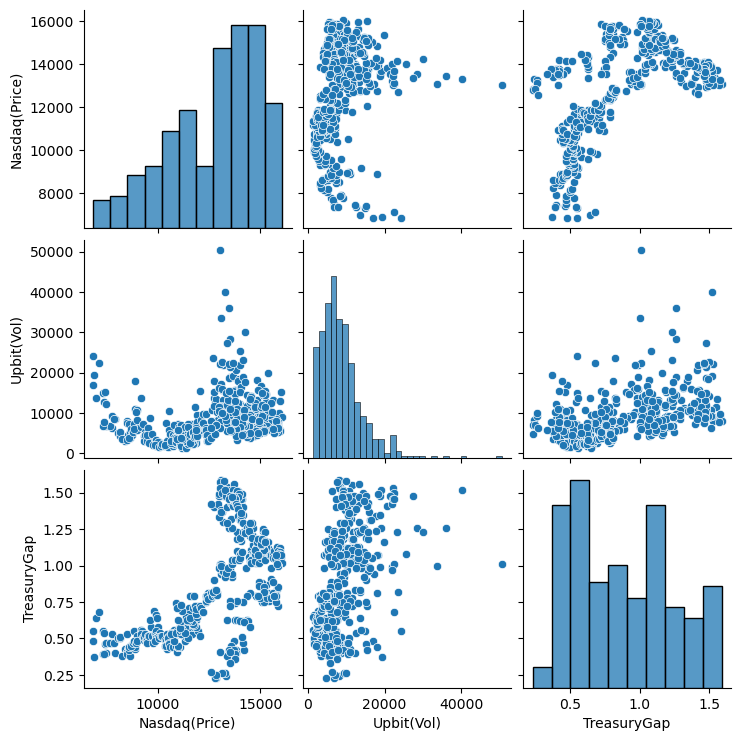

In [190]:
sns.pairplot(df_s)

In [191]:
corr_df=df_s.corr()
corr_df

,Nasdaq(Price),Upbit(Vol),TreasuryGap
Nasdaq(Price),1.000000,0.251325,0.631921
Upbit(Vol),0.251325,1.000000,0.487495
TreasuryGap,0.631921,0.487495,1.000000


In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [193]:
def plot_scatter(df, x_feature, y_feature):
    plt.figure(figsize=(8, 5))
    plt.scatter(df[x_feature], df[y_feature], color='blue', alpha=0.5, edgecolors='black')
    plt.title(f'Scatter Plot of {x_feature} vs {y_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.grid(True)
    plt.show()

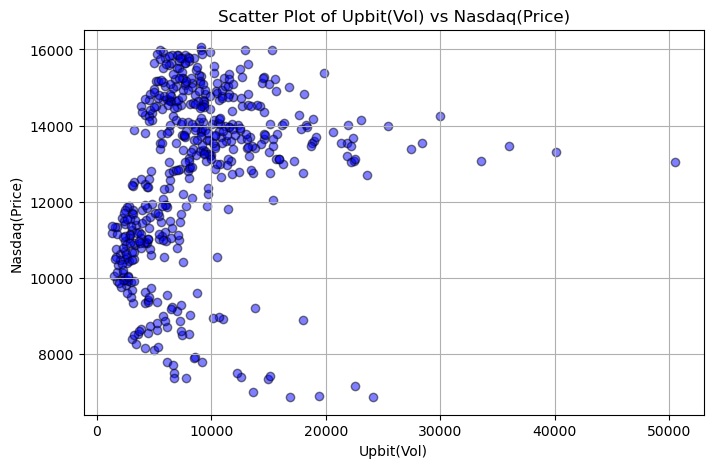

In [194]:
plot_scatter(df_s,'Upbit(Vol)','Nasdaq(Price)')

In [195]:
plt.figure(figsize=(10, 6))
plt.scatter(df_s, df_s['WTI(Vol)'], color='blue', alpha=0.5, edgecolors='black')
plt.title(f'Scatter Plot of Index vs WTI(Vol)')
plt.xlabel('Index')
plt.ylabel('WTI(Vol)')
plt.grid(True)
plt.show()

KeyError: 'WTI(Vol)'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# 막대 그래프 그리기 함수
def plot_bar(df, column):
    # 데이터에서 각 범주의 빈도 계산
    counts = df[column].value_counts()

    # 막대 그래프 그리기
    plt.figure(figsize=(7, 4))
    plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    plt.title(f'Bar Plot of {column}')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
plot_bar(df_s, 'Kospi(Vol)')

In [ ]:
plot_bar(df_s, 'Kospi(Price)')

In [ ]:
# 선형 관계를 찾기 위해 변수 변형
df_0['tan_Kospi(Price)'] = np.tan(df_0['Kospi(Price)']/10000)/500
df_0['pow_TreasuryGap'] = np.power(2, df_0['TreasuryGap'])
df_0['inv_TreasuryGap'] = 1/df_0['TreasuryGap']
df_0['inv_VIX(Price)'] = 1/df_0['VIX(Price)']

# 리스트 순서 변경
col_list = list(df_0.columns)
change_order = {'pow_TreasuryGap':'TreasuryGap', 'tan_Kospi(Price)': 'Kospi(Price)', 'inv_TreasuryGap':'TreasuryGap', 'inv_VIX(Price)' :'VIX(Price)'}

for i in change_order :
    col_list.remove(i) 
    col_list.insert(col_list.index(change_order[i])+1,i)

In [ ]:
# 전체 산점도 작성
sns.pairplot(df_0[col_list])
plt.show()

### 시립대 논문 복원

In [ ]:
df_0.corr()

In [352]:
# 시립대 논문 복원
df_UOS = df

# 필터링 조건 생성
is_kospi = (df_UOS['Kospi(Price)'].isnull()==False)
is_ill = (df_UOS['Illiquidity'].isnull()==False)
is_nasdaq = (df_UOS['Nasdaq(Price)'].isnull()==False)
is_kimchi = (df_UOS['kimchiP'].isnull()==False)
is_gold = (df_UOS['Gold(Price)'].isnull()==False) # 84행에서 금값만 null 이기 때문에 따로 추가해준 행

#df_UOS 시립대 논문 복원용 데이터
conditions = is_gold &is_kospi & is_nasdaq& is_kimchi#&is_ill
df_UOS = df_UOS[conditions]

# log 취한 거래량
df_UOS['Upbit($_Vol)'] = np.log(df_UOS['Upbit($_Vol)'])
df_UOS['kimchiP'] = df_UOS['kimchiP']*100
df_UOS['Binance($_Vol)'] = np.log(df_UOS['Binance($_Vol)'])
df_UOS['RealDollar'] = df_UOS['Exchange(Rate)']*df_UOS['ICDX']/100

# 변수 변형
df_UOS['VIX(Price)^(-1)'] = 1/df_UOS['VIX(Price)']
df_UOS['TreasuryGap^2'] = df_UOS['TreasuryGap']**2

# 요약 통계량 확인 (15p)
df_UOS.describe()

C:\Users\USER\AppData\Local\Temp\ipykernel_19544\1423143655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UOS['Upbit($_Vol)'] = np.log(df_UOS['Upbit($_Vol)'])
C:\Users\USER\AppData\Local\Temp\ipykernel_19544\1423143655.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UOS['kimchiP'] = df_UOS['kimchiP']*100
C:\Users\USER\AppData\Local\Temp\ipykernel_19544\1423143655.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP,RealDollar,VIX(Price)^(-1),TreasuryGap^2
count,478,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,4.780000e+02,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,477.000000,478.000000,478.000000,478.000000,478.000000
mean,2023-03-13 00:27:06.778242560,30209.511642,5997.872280,30751.919449,29605.856768,29571.448661,140925.494602,1310.616737,2493.848808,5.644797e+08,12761.731713,5.008443e+09,20.034854,1890.842885,4054.332636,84.285795,306267.083682,-0.419393,104.396234,21.658769,18.793139,3.706165,0.000249,1.880531,1369.387345,0.053961,0.291711
min,2022-03-15 00:00:00,16544.168397,1756.990238,16708.218423,16202.243059,15781.290000,18198.229200,1209.130005,2155.490000,2.893915e+08,10213.290039,2.184080e+09,12.070000,1623.300049,0.000000,66.739998,0.000000,-1.080000,97.790001,19.996999,17.354852,0.636960,0.000000,-2.391686,1182.408244,0.028777,0.000000
25%,2022-09-13 06:00:00,21774.648059,3313.430151,22403.864073,21192.086179,21432.152500,41427.284405,1287.532532,2409.267500,4.201332e+08,11467.235352,4.517395e+09,14.500000,1810.299988,72.750000,75.335001,272829.500000,-0.690000,102.437500,21.099931,18.333231,2.121068,0.000054,0.759604,1325.878482,0.041749,0.090000
50%,2023-03-14 12:00:00,27675.022198,4941.695845,28215.847171,27277.248535,27281.415000,69225.250970,1310.270019,2494.470000,5.107606e+08,12548.134765,4.901155e+09,19.380001,1918.750000,245.500000,80.165001,317977.500000,-0.440000,103.854999,21.532071,18.774401,3.043064,0.000175,1.687346,1361.664568,0.051600,0.193600
75%,2023-09-10 06:00:00,36375.563522,7296.598853,36757.642106,35902.526559,35518.750000,223351.067095,1333.420044,2592.355000,6.544353e+08,13881.357667,5.332212e+09,23.952499,1978.775024,617.250000,90.022499,356911.750000,-0.252500,105.787500,22.273378,19.200783,4.538893,0.000379,2.690859,1396.448114,0.068966,0.476100
max,2024-03-14 00:00:00,79412.727830,31967.297187,79979.405926,76962.207339,73072.410000,760705.362783,1443.959961,2759.200000,1.736283e+09,16273.379883,9.468130e+09,34.750000,2182.500000,194253.000000,122.110001,594215.000000,0.440000,114.110001,23.571282,21.142147,20.734032,0.001237,9.304659,1631.510584,0.082850,1.166400
std,NaN,11272.145148,3923.975230,11450.999500,10877.474705,10642.535988,138185.961627,46.545586,126.773562,2.044413e+08,1510.471813,7.817072e+08,5.687356,118.284472,21430.886230,12.562661,95737.103136,0.340680,3.052613,0.759687,0.668309,2.435806,0.000245,1.680040,85.461647,0.014786,0.263861


In [413]:
df_UOS.corr()

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP,RealDollar,VIX(Price)^(-1),TreasuryGap^2
time,1.000000,0.627729,-0.108316,0.622372,0.627970,0.620615,-0.404907,0.325217,0.288625,-0.294073,0.749675,0.051662,-0.820583,0.747065,0.004014,-0.644194,0.066051,-0.395529,-0.102701,-0.314272,0.254822,-0.077738,0.028187,0.522954,0.131257,0.844240,0.121436
Upbit(Price),0.627729,1.000000,0.069047,0.999178,0.998812,0.998674,-0.488057,0.034005,0.705881,0.070822,0.881477,0.184896,-0.503462,0.855241,0.026843,-0.077712,-0.014393,0.238097,-0.297206,-0.134597,0.633869,0.106418,0.065790,0.673770,-0.121891,0.555619,-0.313563
Upbit(Vol),-0.108316,0.069047,1.000000,0.088157,0.046123,0.058263,0.405821,-0.011810,-0.056992,-0.011194,-0.080642,0.285937,0.208259,-0.070669,-0.056898,0.154930,0.061728,0.186622,0.067355,0.551518,0.753569,0.816229,-0.054692,0.202682,0.023110,-0.170700,-0.199050
Upbit(High),0.622372,0.999178,0.088157,1.000000,0.998447,0.997226,-0.480657,0.033639,0.706452,0.075406,0.877196,0.188179,-0.494963,0.853147,0.023672,-0.070986,-0.013628,0.244475,-0.294965,-0.124278,0.646758,0.130294,0.069513,0.683454,-0.121075,0.548569,-0.317724
Upbit(Low),0.627970,0.998812,0.046123,0.998447,1.000000,0.997489,-0.497116,0.032904,0.711264,0.075145,0.883680,0.179123,-0.505786,0.858354,0.027923,-0.077019,-0.014060,0.236275,-0.299436,-0.149968,0.616429,0.080829,0.061347,0.674542,-0.123514,0.557339,-0.309746
Binance(Price),0.620615,0.998674,0.058263,0.997226,0.997489,1.000000,-0.501442,0.022679,0.714718,0.084844,0.885194,0.186365,-0.505406,0.857596,0.028923,-0.069897,-0.011657,0.249757,-0.313476,-0.151064,0.629701,0.098244,0.065250,0.638941,-0.135777,0.556649,-0.318880
Binance(Vol),-0.404907,-0.488057,0.405821,-0.480657,-0.497116,-0.501442,1.000000,0.208147,-0.590827,-0.176432,-0.628776,0.062740,0.522293,-0.562978,-0.034748,-0.039452,0.000728,-0.171080,0.496983,0.845933,-0.014520,0.301027,-0.005667,-0.191182,0.359994,-0.547972,0.098168
Exchange(Rate),0.325217,0.034005,-0.011810,0.033639,0.032904,0.022679,0.208147,1.000000,-0.399370,-0.246043,0.008437,-0.159476,0.067509,-0.061084,-0.054467,-0.253713,0.000408,-0.173764,0.795997,0.155167,-0.045790,-0.002608,-0.069171,0.076263,0.957416,-0.017830,-0.149249
Kospi(Price),0.288625,0.705881,-0.056992,0.706452,0.711264,0.714718,-0.590827,-0.399370,1.000000,0.325425,0.733722,0.172171,-0.469062,0.671962,0.055077,0.126173,-0.011176,0.184912,-0.646721,-0.380267,0.387259,0.020601,0.094008,0.431727,-0.538550,0.487051,-0.005701
Kospi(Vol),-0.294073,0.070822,-0.011194,0.075406,0.075145,0.084844,-0.176432,-0.246043,0.325425,1.000000,-0.027595,0.047195,0.197905,0.047663,-0.040069,0.284933,-0.038531,0.325660,-0.309280,-0.125725,0.062135,0.046940,0.048228,-0.123210,-0.280464,-0.187820,-0.117279


In [415]:
col_list= ['Upbit(Vol)','Kospi(Price)','Kospi(Vol)','Gold(Price)']
print(col_list)

# Iliquididty 가 수익률 때문에, 첫 행이 Nan 값이 나옴
# ICDX가 맨 마지막 행이 NaN 값이 나옴
Ana_UOS = df_UOS[1:-1]
best_score = 0
n = len(Ana_UOS)

for L in range(len(col_list) + 1):
    for subset in itertools.combinations(col_list, L):
        X = Ana_UOS[list(subset)]
        y = Ana_UOS['kimchiP']
        X_ = sm.add_constant(X, has_constant='add')
        multi_model = sm.OLS(y, X_)
        fitted_mm = multi_model.fit()
      
        print(subset)
        print(f"Adjusted R-squared: {fitted_mm.rsquared_adj}")

['Upbit(Vol)', 'Kospi(Price)', 'Kospi(Vol)', 'Gold(Price)']
()
Adjusted R-squared: 0.0
('Upbit(Vol)',)
Adjusted R-squared: 0.03944949781370932
('Kospi(Price)',)
Adjusted R-squared: 0.18761509322118652
('Kospi(Vol)',)
Adjusted R-squared: 0.013196653253962798
('Gold(Price)',)
Adjusted R-squared: 0.30874451343071807
('Upbit(Vol)', 'Kospi(Price)')
Adjusted R-squared: 0.23788549055525388
('Upbit(Vol)', 'Kospi(Vol)')
Adjusted R-squared: 0.05220184641578507
('Upbit(Vol)', 'Gold(Price)')
Adjusted R-squared: 0.36556354032744165
('Kospi(Price)', 'Kospi(Vol)')
Adjusted R-squared: 0.26470838259870355
('Kospi(Price)', 'Gold(Price)')
Adjusted R-squared: 0.3143035477110445
('Kospi(Vol)', 'Gold(Price)')
Adjusted R-squared: 0.3298697103440542
('Upbit(Vol)', 'Kospi(Price)', 'Kospi(Vol)')
Adjusted R-squared: 0.3161426687457578
('Upbit(Vol)', 'Kospi(Price)', 'Gold(Price)')
Adjusted R-squared: 0.37179699198994653
('Upbit(Vol)', 'Kospi(Vol)', 'Gold(Price)')
Adjusted R-squared: 0.38627308547394956
('Kospi(Pr

In [361]:
# Iliquididty 가 수익률 때문에, 첫 행이 Nan 값이 나옴
# ICDX가 맨 마지막 행이 NaN 값이 나옴
Ana_UOS = df_UOS[1:-1]

In [363]:
Ana_UOS

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP,RealDollar,VIX(Price)^(-1),TreasuryGap^2
1,2022-03-16,40581.307429,12621.470557,41320.628317,38981.056226,41114.00,88120.761670,1241.680054,2659.23,736353564.0,13436.549805,6.552210e+09,26.670000,1908.000000,104.0,95.040001,293947.0,0.24,98.379997,22.010567,20.054217,5.765147,0.000287,-1.295648,1221.564800,0.037495,0.0576
2,2022-03-17,40939.493050,6441.900307,41781.684383,40594.439902,40917.90,37189.380870,1223.000000,2694.51,546079006.0,13614.780273,5.612090e+09,25.670000,1942.099976,39.0,102.980003,210763.0,0.26,98.010002,21.143101,19.390429,2.899998,0.000137,0.052772,1198.662324,0.038956,0.0676
3,2022-03-18,41947.239055,6364.186934,42319.038495,40834.319398,41757.51,45408.009690,1210.329956,2707.02,644017432.0,13893.839844,8.149290e+09,23.870001,1928.199951,28.0,104.699997,74247.0,0.17,98.230003,21.363078,19.402610,3.539492,0.000387,0.454359,1188.907152,0.041894,0.0289
6,2022-03-21,41415.435121,4418.715829,41934.284731,41170.881801,41002.25,39426.248770,1210.369995,2686.05,502401733.0,13838.459961,5.673940e+09,23.530001,1928.599976,5.0,112.120003,77217.0,0.18,98.500000,21.203569,19.025013,1.843281,0.000000,1.007713,1192.214445,0.042499,0.0324
7,2022-03-22,42387.970594,8395.367481,42955.285998,41001.655062,42364.13,59454.942940,1219.780029,2710.00,489441786.0,14108.820313,5.445100e+09,22.940001,1920.699951,26.0,111.760002,318629.0,0.20,98.489998,21.647031,19.690055,4.608928,0.000280,0.056275,1201.361326,0.043592,0.0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2024-03-07,70876.882811,5792.492528,72096.091788,69829.478313,66823.17,53059.886900,1327.089966,2647.62,462910823.0,16273.379883,5.072790e+09,14.440000,2158.000000,152.0,78.930000,432923.0,-0.41,102.820000,21.988982,19.833018,3.197959,0.000219,6.066328,1364.513903,0.069252,0.1681
724,2024-03-08,72841.699138,8721.933220,74587.108473,71148.515840,68124.19,74261.932842,1321.180054,2680.35,454259855.0,16085.110352,5.411790e+09,14.740000,2178.600098,259.0,78.010002,347533.0,-0.39,102.739998,22.344441,20.269640,4.720638,0.000318,6.924866,1357.380361,0.067843,0.1521
727,2024-03-11,76295.993500,14017.568149,77463.184508,72289.853528,72078.10,75292.825726,1315.979980,2659.84,391384816.0,16019.269531,4.917620e+09,15.220000,2182.500000,738.0,77.930000,329873.0,-0.41,102.870003,22.414646,20.790442,6.780606,0.000000,5.851838,1353.748645,0.065703,0.1681
728,2024-03-12,77220.074922,8326.932695,78097.575773,75541.377641,71452.01,68783.546691,1310.540039,2681.81,403969278.0,16265.639648,5.100330e+09,13.840000,2160.399902,550.0,77.559998,309922.0,-0.42,102.959999,22.315501,20.281665,3.310277,0.000145,8.072642,1349.332011,0.072254,0.1764


C:\Users\USER\Anaconda_\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


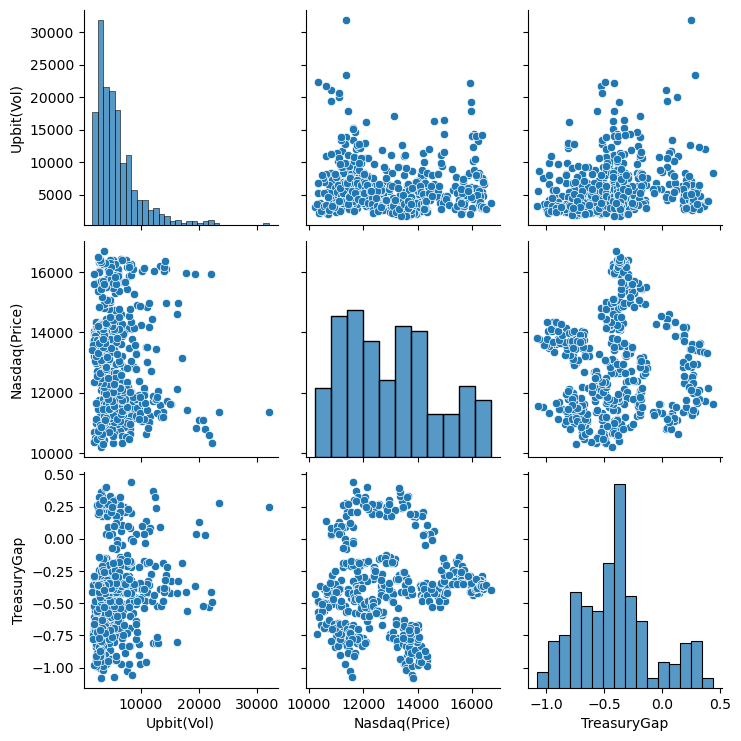

In [52]:
sns.pairplot(X)

In [299]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [471]:
# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [473]:
vif

,VIF Factor,features
0,4.171527,Upbit(Vol)
1,7.611271,Nasdaq(Price)
2,8.683073,TreasuryGap


In [164]:
# 같은 기간에, 건국대 모델 적용
X = Ana_UOS[['Upbit(Vol)','Nasdaq(Price)','TreasuryGap']]
y = Ana_UOS['kimchiP']
X_  = sm.add_constant(X, has_constant = 'add')

multi_model = sm.OLS(y, X_)
fitted_mm = multi_model.fit()
fitted_mm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                kimchiP   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     77.97
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           5.33e-35
Time:                        14:04:12   Log-Likelihood:                -416.57
No. Observations:                 238   AIC:                             841.1
Df Residuals:                     234   BIC:                             855.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4551      1.507      8.927      0.000      10.486      16.425
Upbit(Vol)     7.672e-05    1.3e-05      5.911      0.000    5.11e-05       0.000
Nasdaq(Price)    -0.0018      0.000    -10.055      0.000      -0.002      -0.001
TreasuryGap       7.9928      1.240      6.446      0.000       5.550      10.436
==============================================================================
Omnibus:                       12.054   Durbin-Watson:                   0.642
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.512
Skew:                           0.015   Prob(JB):                     6.44e-07
Kurtosis:                       4.695   Cond. No.                     2.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
Ana_UOS.dropna(how='any',inplace=True)

In [101]:
Ana_UOS.loc[:,'previous_Upbit(Vol)'] = Ana_UOS.loc[:,'Upbit(Vol)'].shift(1)
Ana_UOS.loc[:,'previous_Nasdaq(Price)']= Ana_UOS.loc[:,'Nasdaq(Price)'].shift(1)
Ana_UOS.loc[:,'previous_TreasuryGap']= Ana_UOS.loc[:,'TreasuryGap'].shift(1)
Ana_UOS.loc[:,'previous_kimchiP']=Ana_UOS.loc[:,'kimchiP'].shift(1)
X=Ana_UOS[['Upbit(Vol)','Nasdaq(Price)','TreasuryGap','previous_Upbit(Vol)','previous_Nasdaq(Price)','previous_TreasuryGap','previous_kimchiP']]

In [103]:
X=X.iloc[1:,:]
X

,Upbit(Vol),Nasdaq(Price),TreasuryGap,previous_Upbit(Vol),previous_Nasdaq(Price),previous_TreasuryGap,previous_kimchiP
4,6628.558213,7723.950195,0.15,9501.141609,7714.479980,0.15,-1.308622
5,7162.399609,7728.970215,0.14,6628.558213,7723.950195,0.15,-1.240924
6,9074.417708,7838.959961,0.13,7162.399609,7728.970215,0.14,-0.755402
7,5767.565728,7642.669922,0.13,9074.417708,7838.959961,0.13,0.285381
10,9560.224608,7637.540039,0.17,5767.565728,7642.669922,0.13,-0.141006
...,...,...,...,...,...,...,...
357,2353.860898,8575.620117,0.25,3582.136347,8738.589844,0.33,0.682562
360,7692.575807,7950.680176,0.16,2353.860898,8575.620117,0.25,-0.035350
361,4439.332333,8344.250000,0.26,7692.575807,7950.680176,0.16,3.266976
362,4110.017164,7952.049805,0.32,4439.332333,8344.250000,0.26,1.064525


In [43]:
Ana_UOS

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP,RealDollar,VIX(Price)^(-1),TreasuryGap^2
3,2019-03-18,3935.624623,9501.141609,3958.578019,3897.663237,3987.81,22454.478010,1132.729980,2179.49,257951275.0,7714.479980,2.302140e+09,13.100000,1300.300049,8.0,59.090000,157241.0,0.15,96.519997,18.310243,17.436992,1.547779,0.000000,-1.308622,1093.310943,0.076336,0.0225
4,2019-03-19,3965.700313,6628.558213,3974.540483,3926.803565,4015.53,19893.741815,1131.199951,2177.62,319702553.0,7723.950195,2.457920e+09,13.560000,1305.000000,20.0,59.029999,114822.0,0.15,96.379997,18.196085,17.084580,1.203745,0.000115,-1.240924,1090.250479,0.073746,0.0225
5,2019-03-20,4012.498775,7162.399609,4014.269125,3945.225467,4043.04,23432.300255,1129.719971,2177.10,317606686.0,7728.970215,2.464230e+09,13.910000,1300.500000,2.0,59.830002,786342.0,0.14,95.760002,18.366623,17.173770,1.720715,0.000165,-0.755402,1081.819867,0.071891,0.0196
6,2019-03-21,3992.000000,9074.417708,4056.000000,3920.888889,3980.64,35997.682119,1125.000000,2184.88,342747152.0,7838.959961,2.502810e+09,13.630000,1306.099976,0.0,59.980000,655380.0,0.13,96.500000,18.780408,17.405262,3.384547,0.000056,0.285381,1085.625000,0.073368,0.0169
7,2019-03-22,3981.308175,5767.565728,4002.589109,3964.460768,3986.93,20022.606318,1127.770020,2186.95,333617567.0,7642.669922,2.504740e+09,16.480000,1311.599976,0.0,59.040001,738840.0,0.13,96.650002,18.195394,16.949371,0.957684,0.000046,-0.141006,1089.989747,0.060680,0.0169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2020-03-06,9128.651894,2353.860898,9170.758222,9027.596707,9131.88,43782.948044,1187.469971,2040.22,865588195.0,8575.620117,4.292730e+09,41.939999,1670.800049,175.0,41.279999,1276180.0,0.25,95.949997,19.806527,16.882986,1.568266,0.000057,-0.035350,1139.377402,0.023844,0.0625
360,2020-03-09,8188.936938,7692.575807,8473.520599,7877.410445,7929.87,116968.863268,1187.699951,1954.77,666868332.0,7950.680176,4.554110e+09,54.459999,1674.500000,161.0,31.129999,1774383.0,0.16,94.900002,20.648055,17.958550,7.279457,0.000000,3.266976,1127.127277,0.018362,0.0256
361,2020-03-10,7978.599546,4439.332333,8207.773859,7844.428403,7894.56,86783.443875,1199.959961,1962.93,638564334.0,8344.250000,4.447260e+09,47.299999,1659.099976,48.0,34.360001,1064632.0,0.26,96.410004,20.345100,17.382777,4.554000,0.000579,1.064525,1156.881446,0.021142,0.0676
362,2020-03-11,8027.349028,4110.017164,8134.549167,7734.447859,7934.52,79942.411172,1184.699951,1908.27,679716263.0,7952.049805,4.302610e+09,53.900002,1641.400024,47.0,32.980000,874646.0,0.32,96.510002,20.268040,17.311792,4.984227,0.000149,1.169939,1143.353946,0.018553,0.1024


In [365]:
Ana_UOS1=Ana_UOS.dropna(how='any')
Ana_UOS1

,time,Upbit(Price),Upbit(Vol),Upbit(High),Upbit(Low),Binance(Price),Binance(Vol),Exchange(Rate),Kospi(Price),Kospi(Vol),Nasdaq(Price),Nasdaq(Vol),VIX(Price),Gold(Price),Gold(Vol),WTI(Price),WTI(Vol),TreasuryGap,ICDX,Binance($_Vol),Upbit($_Vol),Volatility,Illiquidity,kimchiP,RealDollar,VIX(Price)^(-1),TreasuryGap^2
1,2022-03-16,40581.307429,12621.470557,41320.628317,38981.056226,41114.00,88120.761670,1241.680054,2659.23,736353564.0,13436.549805,6.552210e+09,26.670000,1908.000000,104.0,95.040001,293947.0,0.24,98.379997,22.010567,20.054217,5.765147,0.000287,-1.295648,1221.564800,0.037495,0.0576
2,2022-03-17,40939.493050,6441.900307,41781.684383,40594.439902,40917.90,37189.380870,1223.000000,2694.51,546079006.0,13614.780273,5.612090e+09,25.670000,1942.099976,39.0,102.980003,210763.0,0.26,98.010002,21.143101,19.390429,2.899998,0.000137,0.052772,1198.662324,0.038956,0.0676
3,2022-03-18,41947.239055,6364.186934,42319.038495,40834.319398,41757.51,45408.009690,1210.329956,2707.02,644017432.0,13893.839844,8.149290e+09,23.870001,1928.199951,28.0,104.699997,74247.0,0.17,98.230003,21.363078,19.402610,3.539492,0.000387,0.454359,1188.907152,0.041894,0.0289
6,2022-03-21,41415.435121,4418.715829,41934.284731,41170.881801,41002.25,39426.248770,1210.369995,2686.05,502401733.0,13838.459961,5.673940e+09,23.530001,1928.599976,5.0,112.120003,77217.0,0.18,98.500000,21.203569,19.025013,1.843281,0.000000,1.007713,1192.214445,0.042499,0.0324
7,2022-03-22,42387.970594,8395.367481,42955.285998,41001.655062,42364.13,59454.942940,1219.780029,2710.00,489441786.0,14108.820313,5.445100e+09,22.940001,1920.699951,26.0,111.760002,318629.0,0.20,98.489998,21.647031,19.690055,4.608928,0.000280,0.056275,1201.361326,0.043592,0.0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2024-03-07,70876.882811,5792.492528,72096.091788,69829.478313,66823.17,53059.886900,1327.089966,2647.62,462910823.0,16273.379883,5.072790e+09,14.440000,2158.000000,152.0,78.930000,432923.0,-0.41,102.820000,21.988982,19.833018,3.197959,0.000219,6.066328,1364.513903,0.069252,0.1681
724,2024-03-08,72841.699138,8721.933220,74587.108473,71148.515840,68124.19,74261.932842,1321.180054,2680.35,454259855.0,16085.110352,5.411790e+09,14.740000,2178.600098,259.0,78.010002,347533.0,-0.39,102.739998,22.344441,20.269640,4.720638,0.000318,6.924866,1357.380361,0.067843,0.1521
727,2024-03-11,76295.993500,14017.568149,77463.184508,72289.853528,72078.10,75292.825726,1315.979980,2659.84,391384816.0,16019.269531,4.917620e+09,15.220000,2182.500000,738.0,77.930000,329873.0,-0.41,102.870003,22.414646,20.790442,6.780606,0.000000,5.851838,1353.748645,0.065703,0.1681
728,2024-03-12,77220.074922,8326.932695,78097.575773,75541.377641,71452.01,68783.546691,1310.540039,2681.81,403969278.0,16265.639648,5.100330e+09,13.840000,2160.399902,550.0,77.559998,309922.0,-0.42,102.959999,22.315501,20.281665,3.310277,0.000145,8.072642,1349.332011,0.072254,0.1764


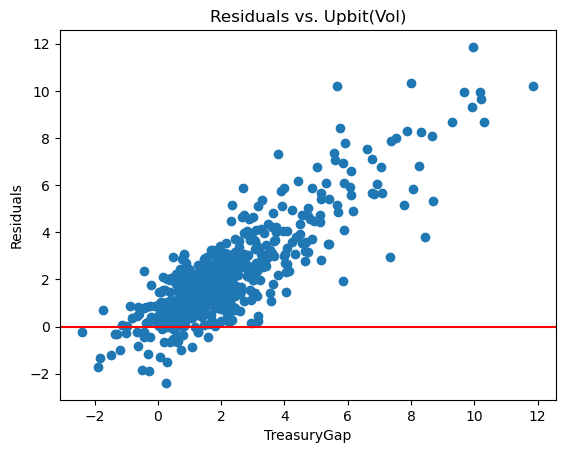

In [48]:
plt.scatter(Ana_UOS1['kimchiP'], Ana_UOS1['previous_kimchiP'])
plt.xlabel('TreasuryGap')
plt.ylabel('Residuals')
plt.title('Residuals vs. Upbit(Vol)')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

In [367]:
# 같은 기간에, 건국대 모델 적용
X=  Ana_UOS1.loc[:,['Upbit(Vol)','Nasdaq(Price)','TreasuryGap']]
y = Ana_UOS1.loc[:,'kimchiP']
X_  = sm.add_constant(X, has_constant = 'add')
#,'previous_Nasdaq(Price)'
multi_model = sm.OLS(y, X_)
fitted_mm = multi_model.fit()
fitted_mm.summary()
#'previous_Upbit(Vol)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                kimchiP   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     59.89
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           7.97e-33
Time:                        14:15:11   Log-Likelihood:                -835.26
No. Observations:                 476   AIC:                             1679.
Df Residuals:                     472   BIC:                             1695.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.5957      0.580     -9.650      0.000      -6.735      -4.456
Upbit(Vol)        0.0001   1.68e-05      6.762      0.000    8.07e-05       0.000
Nasdaq(Price)     0.0005    4.3e-05     12.140      0.000       0.000       0.001
TreasuryGap      -0.3014      0.194     -1.557      0.120      -0.682       0.079
==============================================================================
Omnibus:                       26.912   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.108
Skew:                           0.342   Prob(JB):                     4.84e-12
Kurtosis:                       4.470   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
Ana_UOS[['Upbit(Vol)','Nasdaq(Price)','TreasuryGap']]

,Upbit(Vol),Nasdaq(Price),TreasuryGap
4,6628.558213,7723.950195,0.15
5,7162.399609,7728.970215,0.14
6,9074.417708,7838.959961,0.13
7,5767.565728,7642.669922,0.13
10,9560.224608,7637.540039,0.17
...,...,...,...
357,2353.860898,8575.620117,0.25
360,7692.575807,7950.680176,0.16
361,4439.332333,8344.250000,0.26
362,4110.017164,7952.049805,0.32


## 잔차의 정규성 확인

In [369]:
# 표준화 잔차 계산
standardized_residuals = fitted_mm.get_influence().resid_studentized_external

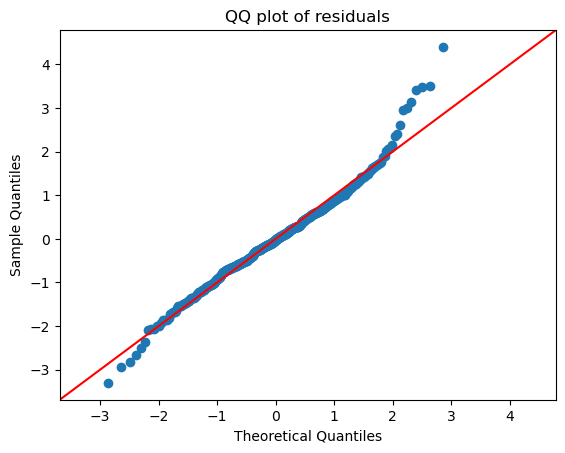

In [370]:

# 잔차 추출
residuals = fitted_mm.resid

# QQ plot 생성
fig = sm.qqplot(standardized_residuals, line='45', fit=True)
plt.title('QQ plot of residuals')
plt.show()


## 독립변수와 잔차의 독립성 확인

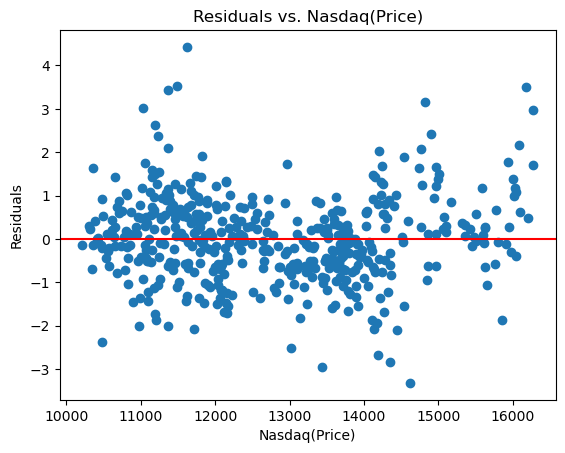

In [374]:
# 'Kospi(Price)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1['Nasdaq(Price)'], standardized_residuals)
plt.xlabel('Nasdaq(Price)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Nasdaq(Price)')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

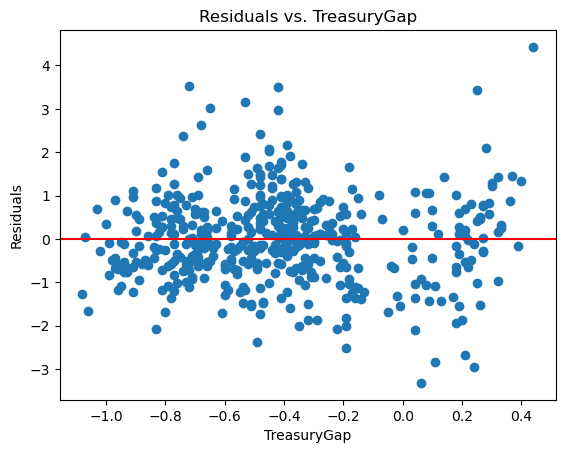

In [376]:
# 'Upbit(Vol)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1['TreasuryGap'], standardized_residuals)
plt.xlabel('TreasuryGap')
plt.ylabel('Residuals')
plt.title('Residuals vs. TreasuryGap')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

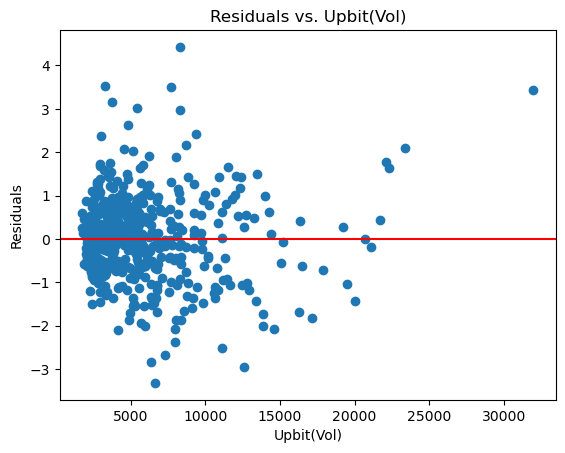

In [377]:
# 'Upbit(Vol)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1['Upbit(Vol)'], standardized_residuals)
plt.xlabel('Upbit(Vol)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Upbit(Vol)')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

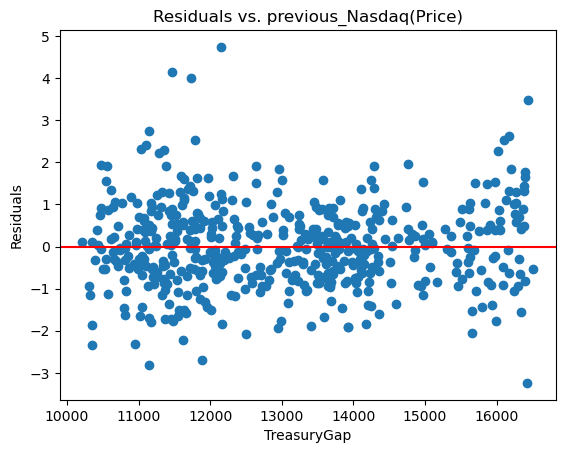

In [196]:
# 'Upbit(Vol)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1['previous_Nasdaq(Price)'], standardized_residuals)
plt.xlabel('TreasuryGap')
plt.ylabel('Residuals')
plt.title('Residuals vs. previous_Nasdaq(Price)')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

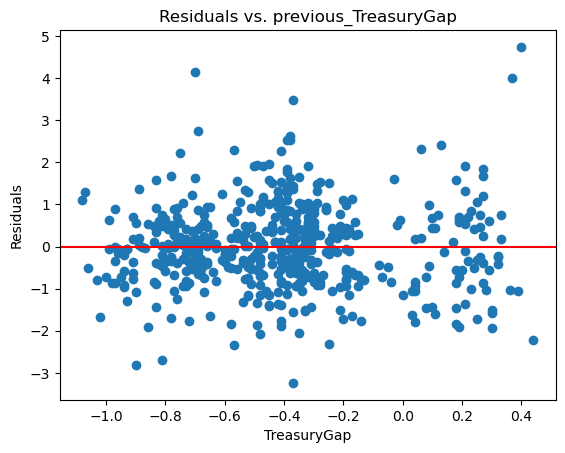

In [197]:
# 'Upbit(Vol)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1['previous_TreasuryGap'], standardized_residuals)
plt.xlabel('TreasuryGap')
plt.ylabel('Residuals')
plt.title('Residuals vs. previous_TreasuryGap')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

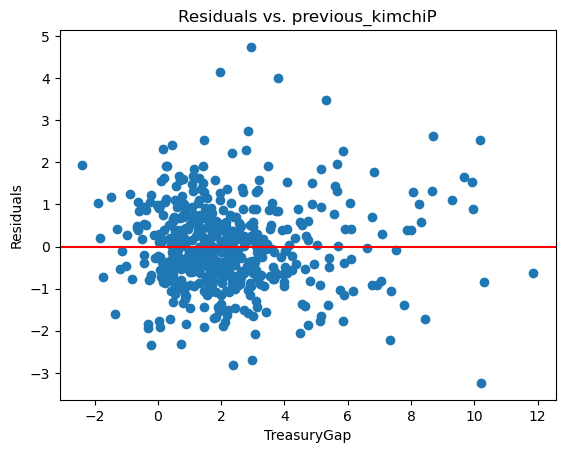

In [198]:
# 'Upbit(Vol)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1['previous_kimchiP'], standardized_residuals)
plt.xlabel('TreasuryGap')
plt.ylabel('Residuals')
plt.title('Residuals vs. previous_kimchiP')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

## 회귀식에서의 종속변수와의 독립성

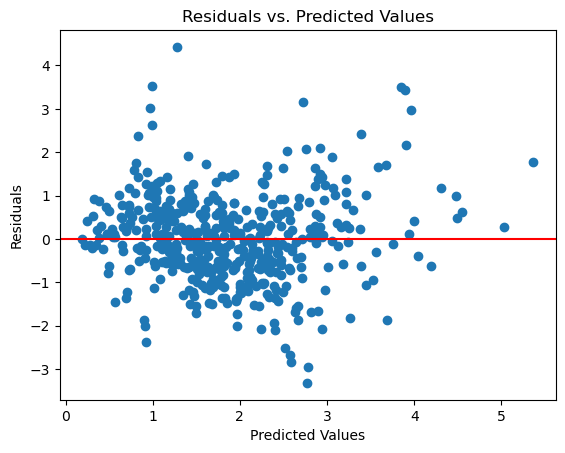

In [380]:
# 예측값
predictions = fitted_mm.predict(X_)

# 예측값에 따른 잔차의 scatter plot
plt.scatter(predictions, standardized_residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='red', linestyle='-')  # y=0 기준선 추가
plt.show()

In [208]:
# 조건을 괄호로 묶기
filtered_df = Ana_UOS1[(standardized_residuals > 3) | (standardized_residuals < -3)]
filtered_df.loc[:,['Upbit(Vol)','Nasdaq(Price)','TreasuryGap']]

,Upbit(Vol),Nasdaq(Price),TreasuryGap,previous_kimchiP
60,8307.106093,11623.250000,0.44,2.933491
62,31967.297187,11364.240234,0.25,3.802344
266,3278.515197,11482.450195,-0.72,1.951043
746,7510.923585,16384.470703,-0.29,10.225591
764,5005.558568,16175.089844,-0.38,5.309744


In [201]:
standardized_residuals.shape

(518,)

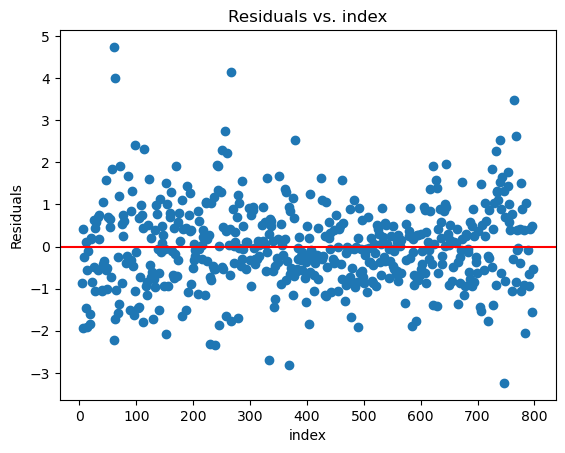

In [206]:
# 'Upbit(Vol)'를 X축으로 하는 scatter plot 생성
plt.scatter(Ana_UOS1.index, standardized_residuals)
plt.xlabel('index')
plt.ylabel('Residuals')
plt.title('Residuals vs. index')
plt.axhline(y=0, color='r', linestyle='-')  # y=0을 기준선으로 추가
plt.show()

## 인덱스에 따른 잔차그림으로는 자기상관성 확인 어려움

In [203]:
# 레버리지 값 계산
influence = fitted_mm.get_influence()
leverage = influence.hat_matrix_diag

# 높은 레버리지 포인트 찾기
high_leverage_points = leverage > 2 * leverage.mean()  # 일반적으로 평균의 2배 이상을 높은 레버리지로 간주
filtered_data_high_leverage = Ana_UOS1[high_leverage_points]


In [204]:
filtered_data_high_leverage.loc[:,['Upbit(Vol)','Nasdaq(Price)','TreasuryGap','previous_Nasdaq(Price)','previous_TreasuryGap','previous_kimchiP']]

,Upbit(Vol),Nasdaq(Price),TreasuryGap,previous_Nasdaq(Price),previous_TreasuryGap,previous_kimchiP
6,12621.470557,13436.549805,0.24,12948.620117,0.30,-0.303631
7,6441.900307,13614.780273,0.26,13436.549805,0.24,-1.295648
15,5670.827515,14169.299805,0.18,14191.839844,0.21,-1.149711
19,6629.178471,14619.639648,0.06,14354.900391,0.11,-1.354511
20,4136.114493,14442.269531,0.04,14619.639648,0.06,-1.824595
61,12076.374930,11737.669922,0.37,11623.250000,0.44,7.332764
62,31967.297187,11364.240234,0.25,11737.669922,0.37,3.802344
63,23389.063427,11370.959961,0.28,11364.240234,0.25,8.444526
64,12398.918801,11805.000000,0.32,11370.959961,0.28,5.763806
95,21092.064199,10809.230469,0.03,11340.019531,0.09,2.279628


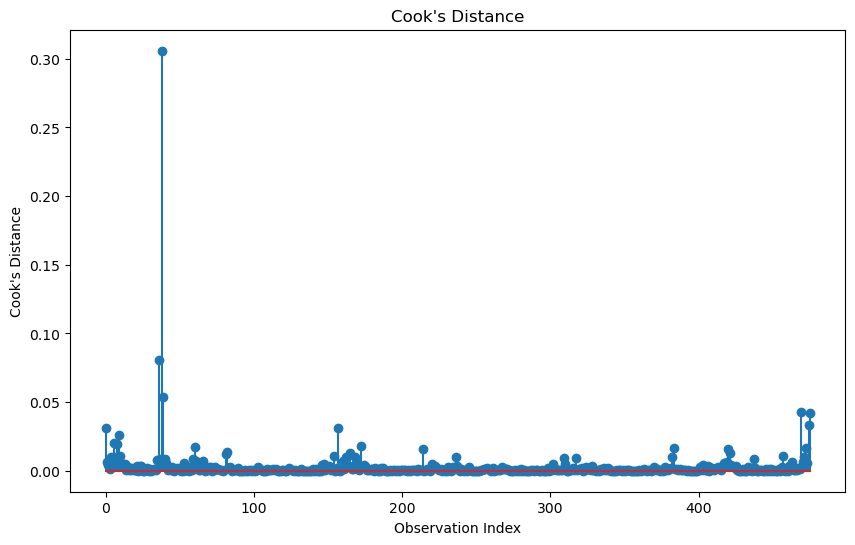

High influence points with Cook's Distance > 1:
Empty DataFrame
Columns: [time, Upbit(Price), Upbit(Vol), Upbit(High), Upbit(Low), Binance(Price), Binance(Vol), Exchange(Rate), Kospi(Price), Kospi(Vol), Nasdaq(Price), Nasdaq(Vol), VIX(Price), Gold(Price), Gold(Vol), WTI(Price), WTI(Vol), TreasuryGap, ICDX, Binance($_Vol), Upbit($_Vol), Volatility, Illiquidity, kimchiP, RealDollar, VIX(Price)^(-1), TreasuryGap^2]
Index: []


In [382]:
# 영향력 있는 관측치 (Cook's Distance) 계산
influence = fitted_mm.get_influence()
cooks_d, p_values = influence.cooks_distance

# Cook's Distance 그래프
plt.figure(figsize=(10,6))
plt.stem(cooks_d)
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

# Cook's Distance가 1보다 큰 데이터 필터링
high_influence = cooks_d > 1
filtered_high_influence_data = Ana_UOS1[high_influence]

print("High influence points with Cook's Distance > 1:")
print(filtered_high_influence_data)

## COOK'S DISTANCE 1보다 큰 점은 보이지 않아 영향력 있는 관측치로 판단할만한 관측치 존재하지 않음

## 자기상관성 확인

## 더빈 왓슨 검정에서 0.513으로 자기상관성이 높게 나와 ar(1) 모형이라 가정하고 회귀식 변환

In [66]:
import statsmodels.api as sm

In [68]:
# 잔차에서 자기상관 계수 추정
rho = sm.regression.yule_walker(residuals, order=1)[0]
rho

array([0.72922288])

In [72]:
# 특정 행에서 rho를 곱한 이전 행을 뺀 결과 계산
X_transformed = X - 0.72922288* X.shift(1)

In [74]:
# NaN 값 처리
X_t = X_transformed.dropna()
X_t

,Upbit(Vol),Nasdaq(Price),TreasuryGap
5,977.071539,3774.106834,0.103110
6,8530.698835,3994.119751,0.021233
7,-2761.964802,3816.540727,0.084987
8,1666.605839,3965.630563,-0.019598
11,-222.194895,3706.754056,0.056032
...,...,...,...
791,311.522312,4457.914337,-0.087480
792,1019.593001,4420.803493,-0.114772
795,695.618517,4472.103866,-0.100188
796,506.497584,4560.499946,-0.090188


In [76]:
Y_t = y-rho*y.shift(1)
Y_t = Y_t.dropna()
Y_t

5     -0.455034
6     -1.074233
7      0.997588
8      0.415877
11     0.676384
         ...   
791    0.128783
792    1.525195
795   -0.518675
796    1.570442
798    0.639195
Name: kimchiP, Length: 518, dtype: float64

In [78]:
# 변환된 모델 적합
X_  = sm.add_constant(X_t, has_constant = 'add')
transformed_model = sm.OLS(Y_t, X_)
transformed_results = transformed_model.fit()

print(transformed_results.summary())

                            OLS Regression Results                            
Dep. Variable:                kimchiP   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     12.66
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           5.41e-08
Time:                        09:10:23   Log-Likelihood:                -774.19
No. Observations:                 518   AIC:                             1556.
Df Residuals:                     514   BIC:                             1573.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2077      0.351     -3.436

## 더빗왓슨 검정량 2.123로 자기상관성 존재하지 않게 됨

# RandomFroestRegressor 활용하여 추가 테스트

In [22]:
#평가지표 만들기
def evaluation(y_test , pred):

    mae = mean_absolute_error(y_test,pred) ## mae
    mse = mean_squared_error(y_test,pred) # mse
    rmse = np.sqrt(mean_squared_error(y_test,pred)) # rmse

    print('mae: {}, mse: {}, rmse:{}'.format(mae, mse, rmse))

R2 Score(Upbit(Vol)) :0.9322245092816372
mae: 2.8298555851074934, mse: 18.866136446648945, rmse:4.343516599099046


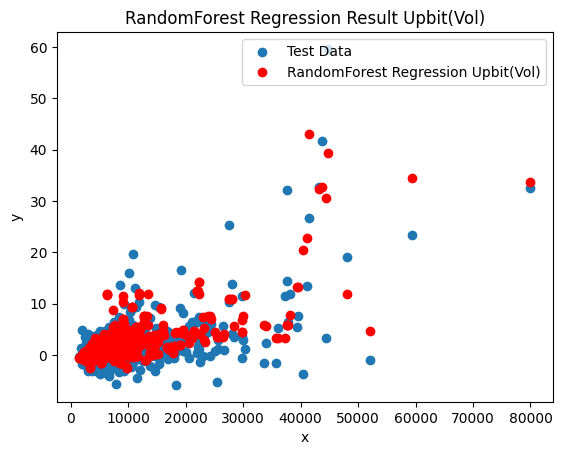

R2 Score(Kospi(Price)) :0.8723071471096033
mae: 2.6560912124294824, mse: 25.69277667256482, rmse:5.068804264574124


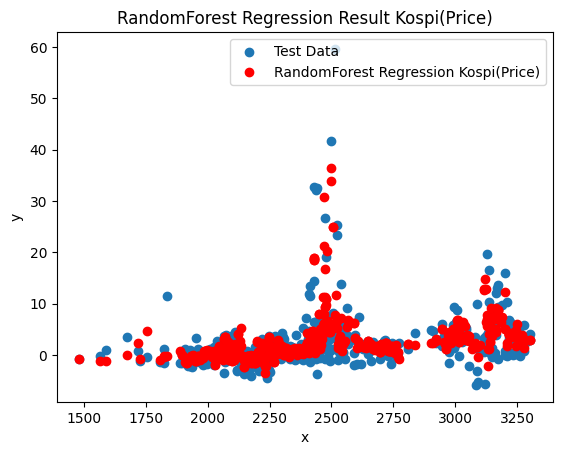

R2 Score(Kospi(Vol)) :0.8196518150699692
mae: 3.7288362753280784, mse: 46.32820167566025, rmse:6.8064823275801025


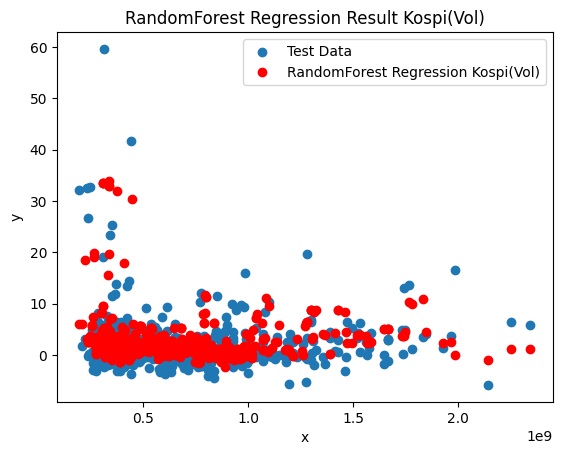

R2 Score(Gold(Price)) :0.7391424693756212
mae: 3.456952484760672, mse: 44.64388557149544, rmse:6.681608007919609


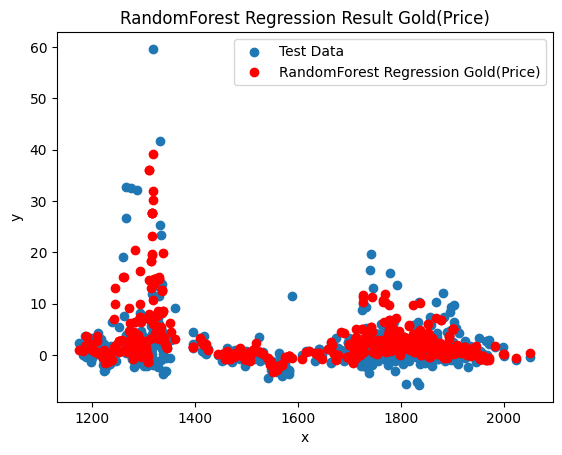

In [23]:
# 1개의 변수 만으로 RandomForestRegressor 적용해보기
model = RandomForestRegressor()
for i in col_list :
    x = pd.DataFrame(Ana_UOS[i])
    y = Ana_UOS['kimchiP']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)


    print('R2 Score({}) :{}'.format(i,model.score(x_train, y_train))) #test,test로 바꾸는게 맞긴한데... test로 바꿀 경우, 예측에 대한 score는 음수, +무한까지 나옴
    evaluation(y_test , y_pred)

    plt.scatter(x_test, y_test, label='Test Data')
    plt.plot(x_test, y_pred, 'or', label='RandomForest Regression {}'.format(i))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('RandomForest Regression Result {}'.format(i))
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


R2 Score :0.8945957790014593


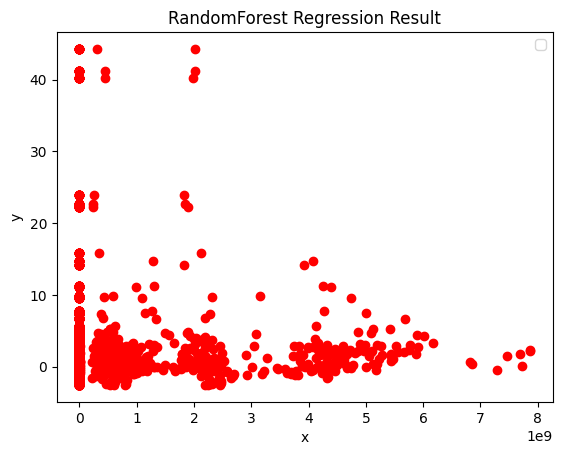

In [24]:
# 모든 변수 활용하여 RandomForestRegressor 적용
col_list = list(df_UOS.columns)
remove_col = ['kimchiP','time', 'Upbit(Price)', 'Upbit(Vol)', 'Upbit(High)', 'Upbit(Low)', 'Binance(Price)', 'Binance(Vol)', 'Exchange(Rate)']
for i in remove_col :
    col_list.remove(i)

Ana_UOS = df_UOS

y = Ana_UOS['kimchiP']
x = Ana_UOS[col_list]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


model.fit(x_train, y_train)
y_pred = model.predict(x_test)


print('R2 Score :{}'.format(model.score(x_test, y_test)))

#plt.scatter(x_test, y_test, label='Test Data')
plt.plot(x_test, y_pred, 'or')#, label='Symbolic Regression{}'.format(i))
plt.xlabel('x')
plt.ylabel('y')
plt.title('RandomForest Regression Result')
plt.legend()
plt.show()